# Computer Vision Analysis
#### By Ronny Toribio, Kadir O. Altunel, Michael Cook-Stahl
#### Based on [Hands on Machine Learning 2nd edition](https://github.com/ageron/handson-ml2/), [FER2013 candidate 1](https://www.kaggle.com/code/ritikjain00/model-training-fer-13) and [FER2013 candidate 2](https://www.kaggle.com/code/gauravsharma99/facial-emotion-recognition/notebook)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import modules and declare constants

In [ ]:
%matplotlib inline
import os
import os.path
import shutil
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, ModelCheckpoint 
from google.colab import drive

### Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_ZOOM = 0.3
IMAGE_SHAPE = (48, 48)
INPUT_SHAPE = (48, 48, 1)
TRAIN_DIR = os.path.join("fer2013", "train")
TEST_DIR = os.path.join("fer2013", "test")
GOOGLE_DRIVE_PATH = "/content/drive/MyDrive/Machine Learning/GridSearch"

### Mount Google Drive and unzip dataset

In [ ]:
drive.mount('/content/drive')
os.makedirs(GOOGLE_DRIVE_PATH, exist_ok=True)
!unzip /content/drive/MyDrive/FER.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

### Load Facial Emotion Recognition dataset
#### training, validation, and testing

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=IMAGE_ZOOM, horizontal_flip=True,
                                   validation_split=0.10)
Xy_train = train_datagen.flow_from_directory(TRAIN_DIR, batch_size=BATCH_SIZE, 
                                   target_size=IMAGE_SHAPE, shuffle=True, subset="training",
                                   color_mode="grayscale", class_mode="categorical")

Xy_valid = train_datagen.flow_from_directory(TRAIN_DIR, batch_size=BATCH_SIZE, 
                                   target_size=IMAGE_SHAPE, shuffle=True, subset="validation",
                                   color_mode="grayscale", class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255)
Xy_test = test_datagen.flow_from_directory(TEST_DIR, batch_size=BATCH_SIZE,
                                   target_size=IMAGE_SHAPE, shuffle=True,
                                   color_mode="grayscale", class_mode="categorical")

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Build and compile CNN model

In [ ]:
def build_model(main_activation, main_initializer, use_conv_block3=False):
    model = Sequential(name="cnn_model")
    # Convolution Block 0
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, input_shape=INPUT_SHAPE,
              name="conv_block_0_conv_layer_0_input"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_0_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid", name="conv_block_0_maxpool"))
    model.add(Dropout(0.25, name="conv_block_0_dropout"))

    # Convolution Block 1
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), name="conv_block_1_conv_layer_0"))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), name="conv_block_1_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_1_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_1_maxpool"))
    model.add(Dropout(0.25, name="conv_block_1_dropout"))
        
    # Convolution Block 2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01),
              name="conv_block_2_conv_layer_0"))
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation=main_activation,
              kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), 
              name="conv_block_2_conv_layer_1"))
    model.add(BatchNormalization(name="conv_block_2_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_2_maxpool"))
    model.add(Dropout(0.25, name="conv_block_2_dropout"))
    
    # Convolution Block 3
    if use_conv_block3:
        model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation=main_activation,
                  kernel_initializer= main_initializer, kernel_regularizer=l2(0.01),
                  name="conv_block_3_conv_layer_0"))
        model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", activation=main_activation,
                  kernel_initializer= main_initializer, kernel_regularizer=l2(0.01), 
                  name="conv_block_3_conv_layer_1"))
        model.add(BatchNormalization(name="conv_block_3_batchnorm"))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_3_maxpool"))
        model.add(Dropout(0.25, name="conv_block_3_dropout"))

    # Classification Block
    model.add(Flatten(name="class_block_flatten"))
    model.add(Dense(2048, activation=main_activation, kernel_initializer="he_normal",
              name="class_block_flatten_dense_0"))
    model.add(BatchNormalization(name="class_block_batchnorm"))
    model.add(Dropout(0.5, name="class_block_dropout"))
    model.add(Dense(7, activation="softmax", name="class_block_dense_output"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=["accuracy"])
    return model

def build_model_with_activation_layers(main_activation_layer, main_activation_name, main_initializer,
                                       use_conv_block3=False):
    model = Sequential(name="cnn_model")
    # Convolution Block 0
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=INPUT_SHAPE,
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_0_input"))
    model.add(main_activation_layer(name="conv_block_0_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same",
              kernel_initializer= main_initializer, name="conv_block_0_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_0_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_0_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid", name="conv_block_0_maxpool"))
    model.add(Dropout(0.25, name="conv_block_0_dropout"))

    # Convolution Block 1
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_1_conv_layer_0"))
    model.add(main_activation_layer(name="conv_block_1_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_1_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_1_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_1_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_1_maxpool"))
    model.add(Dropout(0.25, name="conv_block_1_dropout"))
        
    # Convolution Block 2
    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
              kernel_initializer= main_initializer, name="conv_block_2_conv_layer_0"))
    model.add(main_activation_layer(name="conv_block_2_{}_0".format(main_activation_name)))
    model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01), 
              kernel_initializer= main_initializer, name="conv_block_2_conv_layer_1"))
    model.add(main_activation_layer(name="conv_block_2_{}_1".format(main_activation_name)))
    model.add(BatchNormalization(name="conv_block_2_batchnorm"))
    model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_2_maxpool"))
    model.add(Dropout(0.25, name="conv_block_2_dropout"))
    
    # Convolution Block 3
    if use_conv_block3:
        model.add(Conv2D(filters=512, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01),
                  kernel_initializer= main_initializer, name="conv_block_3_conv_layer_0"))
        model.add(main_activation_layer(name="conv_block_3_{}_0".format(main_activation_name)))
        model.add(Conv2D(filters=1024, kernel_size=(3, 3), padding="same", kernel_regularizer=l2(0.01), 
                  kernel_initializer= main_initializer, name="conv_block_3_conv_layer_1"))
        model.add(main_activation_layer(name="conv_block_3_{}_1".format(main_activation_name)))
        model.add(BatchNormalization(name="conv_block_3_batchnorm"))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="valid", name="conv_block_3_maxpool"))
        model.add(Dropout(0.25, name="conv_block_3_dropout"))

    # Classification Block
    model.add(Flatten(name="class_block_flatten"))
    model.add(Dense(2048, kernel_initializer= main_initializer, name="class_block_flatten_dense_0"))
    model.add(main_activation_layer(name="class_block_{}_0".format(main_activation_name)))
    model.add(BatchNormalization(name="class_block_batchnorm"))
    model.add(Dropout(0.5, name="class_block_dropout"))
    model.add(Dense(7, activation="softmax", name="class_block_dense_output"))
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=["accuracy"])
    return model



### Early stopping callback

In [ ]:
early_stopping_cb = EarlyStopping(min_delta=0.00005, patience=11, verbose=1, restore_best_weights=True)

### Reduce learning rate on plateau callback

In [ ]:
reduce_lr_cb = ReduceLROnPlateau(factor=0.5, patience=7, min_l=1e-7, verbose=1)

### Grid Search Hyperparameters for our model

In [ ]:
param_grid = [
    {"main_activation": ["relu", "elu"], "main_initializer":["he_normal"], "use_conv_block3": [True, False]},
    {"main_activation": ["selu"], "main_initializer":["lecun_normal"], "use_conv_block3": [True, False]},
    {"main_activation_layer": [LeakyReLU], "main_activation_name": ["leaky_relu"],
     "main_initializer":["he_normal"], "use_conv_block3": [True, False]}
]

best_model = None
best_model_accuracy = None
best_model_history = None
best_model_name = ""
convolution_blocks = [3, 4]
scores = {}

for params in list(ParameterGrid(param_grid)):
    cur_name = ""
    cur_model = None
    
    # Build model from paramters
    if "main_activation" in params:
        cur_name = "{}+{}+{}-convolution-blocks".format(params["main_activation"], params["main_initializer"],
                                     convolution_blocks[params["use_conv_block3"]])
        cur_model = build_model(**params)
    else:
        cur_name = "{}+{}+{}-convolution-blocks".format(params["main_activation_name"], params["main_initializer"],
                                     convolution_blocks[params["use_conv_block3"]])
        cur_model = build_model_with_activation_layers(**params)
    print(cur_name)
    if cur_model is None:
        continue
        
    # Save model architecture as JSON
    model_json = cur_model.to_json()
    with open(cur_name + ".json", "w") as f:
        f.write(model_json)
        
    # Train model
    csv_cb = CSVLogger(cur_name + "-training.csv")
    cur_weights = cur_name + "-weights.h5"
    checkpoint_cb = ModelCheckpoint(cur_weights, monitor = 'accuracy', verbose =1, 
                                    save_best_only = True, save_weights_only = True)
    history = cur_model.fit(Xy_train, epochs=80,
                            validation_data=(Xy_valid),
                            steps_per_epoch=Xy_train.n // BATCH_SIZE,
                            validation_steps=Xy_valid.n // BATCH_SIZE,
                            callbacks=[early_stopping_cb, reduce_lr_cb, 
                                       csv_cb, checkpoint_cb])
    
    # Save statistics and compare accuracies
    cur_model.load_weights(cur_weights)
    loss, accuracy = cur_model.evaluate(Xy_test)
    scores[accuracy] = [cur_name, loss]
    if best_model_accuracy is None or accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = cur_model
        best_model_history = history
        best_model_name = cur_name

relu+he_normal+4-convolution-blocks
Epoch 1/80
807/807 [==============================] - ETA: 0s - loss: 63.3068 - accuracy: 0.2108
Epoch 1: accuracy improved from -inf to 0.21078, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==============================] - 40s 37ms/step - loss: 63.3068 - accuracy: 0.2108 - val_loss: 53.0852 - val_accuracy: 0.2704 - lr: 1.0000e-04
Epoch 2/80
807/807 [==============================] - ETA: 0s - loss: 42.5304 - accuracy: 0.2742
Epoch 2: accuracy improved from 0.21078 to 0.27421, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==============================] - 29s 35ms/step - loss: 42.5304 - accuracy: 0.2742 - val_loss: 34.4212 - val_accuracy: 0.2219 - lr: 1.0000e-04
Epoch 3/80
807/807 [==============================] - ETA: 0s - loss: 25.4300 - accuracy: 0.3046
Epoch 3: accuracy improved from 0.27421 to 0.30462, saving model to relu+he_normal+4-convolution-blocks-weights.h5
807/807 [==================

### Print best model

In [ ]:
print("Best Model: {} Accuracy: {}".format(best_model_name, best_model_accuracy))

Best Model: relu+he_normal+4-convolution-blocks Accuracy: 0.6791585683822632


### Print model accuracies

In [ ]:
for accuracy in sorted(scores.keys(), reverse=True):
    name, loss = scores[accuracy]
    print("Name: {} Accuracy: {} Loss: {}".format(name, accuracy, loss))

Name: relu+he_normal+4-convolution-blocks Accuracy: 0.6791585683822632 Loss: 1.0805416107177734
Name: relu+he_normal+3-convolution-blocks Accuracy: 0.6734466552734375 Loss: 1.121889352798462
Name: leaky_relu+he_normal+4-convolution-blocks Accuracy: 0.662580132484436 Loss: 1.0776439905166626
Name: leaky_relu+he_normal+3-convolution-blocks Accuracy: 0.6572861671447754 Loss: 1.0680756568908691
Name: selu+lecun_normal+3-convolution-blocks Accuracy: 0.6408470273017883 Loss: 1.0720915794372559
Name: elu+he_normal+3-convolution-blocks Accuracy: 0.6398718357086182 Loss: 1.0616121292114258
Name: selu+lecun_normal+4-convolution-blocks Accuracy: 0.639314591884613 Loss: 1.1332910060882568
Name: elu+he_normal+4-convolution-blocks Accuracy: 0.6356924176216125 Loss: 1.1485251188278198


### Convert histories into graph images

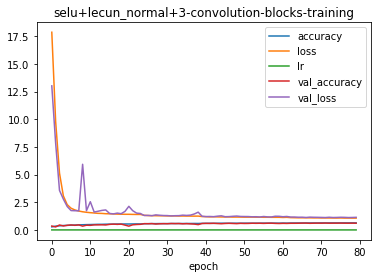

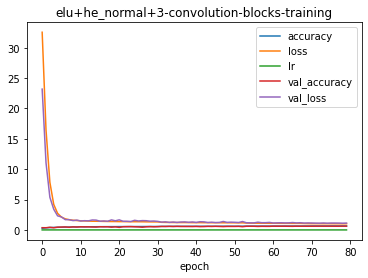

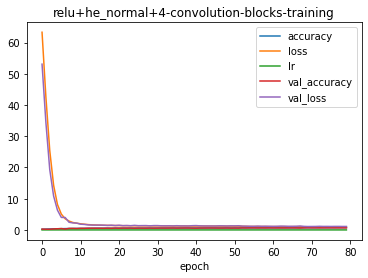

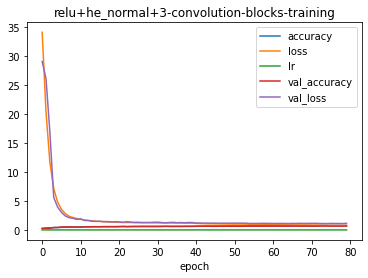

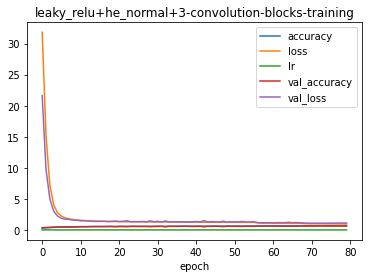

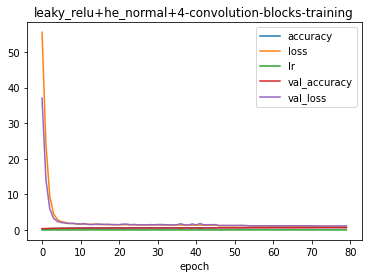

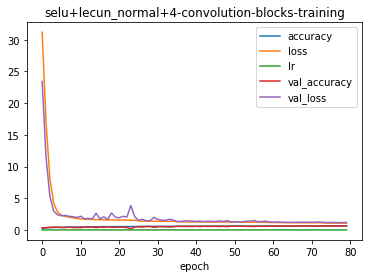

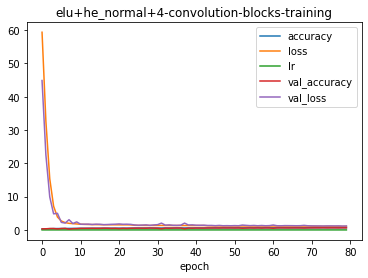

In [ ]:
for csv_file in glob("*-training.csv"):
    name = ".".join(csv_file.split(".")[:-1])
    training = pd.read_csv(csv_file, index_col="epoch")
    fig, ax1 = plt.subplot(1, 1)
    ax2 = ax1.twinx()
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Accuracy", color="b")
    ax2.set_ylabel("Loss", color="y")
    ax1.plot(training["epoch"], training["accuracy"], "b-", label="accuracy")
    ax1.plot(training["epoch"], training["val_accuracy"], "r-", label="val_accuracy")
    ax1.plot(training["epoch"], training["lr"], "g-", label="lr")
    ax2.plot(training["epoch"], training["loss"], "y-", label="loss")
    ax2.plot(training["epoch"], training["val_loss"], "m-", label="val_loss")
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    plt.legend(h1+h2, l1+l2)
    plt.title(name)
    plt.savefig(name + ".png")

### Copy models to Google Drive

In [ ]:
for f in os.listdir("."):
    shutil.copy(f, GOOGLE_DRIVE_PATH)

FileNotFoundError: ignored